# Forest Cover Prediction 

In [24]:
# %pip install xgboost
# %pip install lightgbm
# %pip install catboost

In [67]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import (StandardScaler, PowerTransformer)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix


### Data overview

In [26]:
df = pd.read_csv('./forest_cover_prediction/train.csv')
df = df.drop('Id',axis=1)   #dropping 'id' column since it is not relevent to input
df.head(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
5,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2
6,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,0,0,0,5
7,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,5
8,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,0,0,0,5
9,2612,59,10,247,11,636,228,219,124,6230,...,0,0,0,0,0,0,0,0,0,5


### Data Analysis
In this section, I will performing some basic exploratory data analysis like:
1. Correlation Heatmap - To check relationship between features
2. Skewness-check plot - To check how skewed each of the features are. 

In [27]:
# distribution of our dataset
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


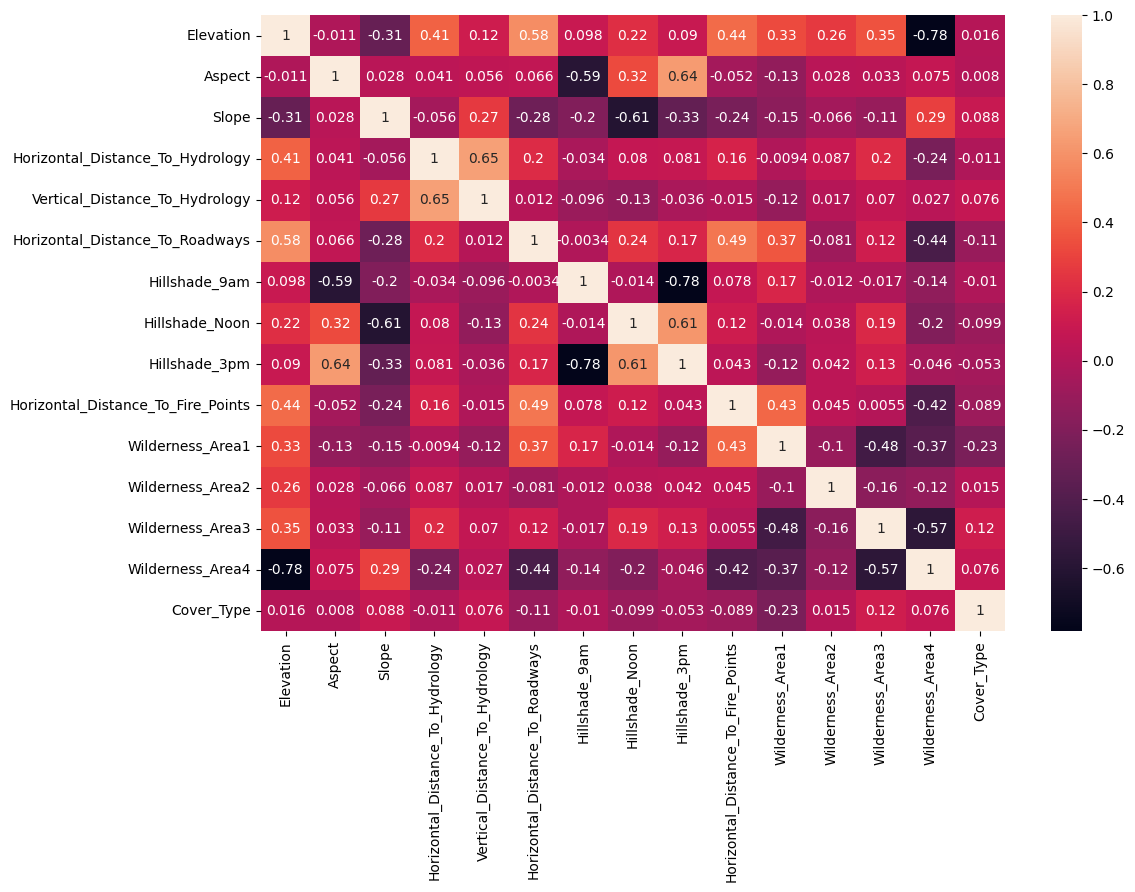

In [28]:
# correlation heatmap (except soil_type as they already in one-hot encoding)
df_temp = df.drop(['Soil_Type' + str(i) for i in range(1, 41)], axis=1)
plt.figure(figsize=(12, 8))   # width=12, height=8
corr = df_temp.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

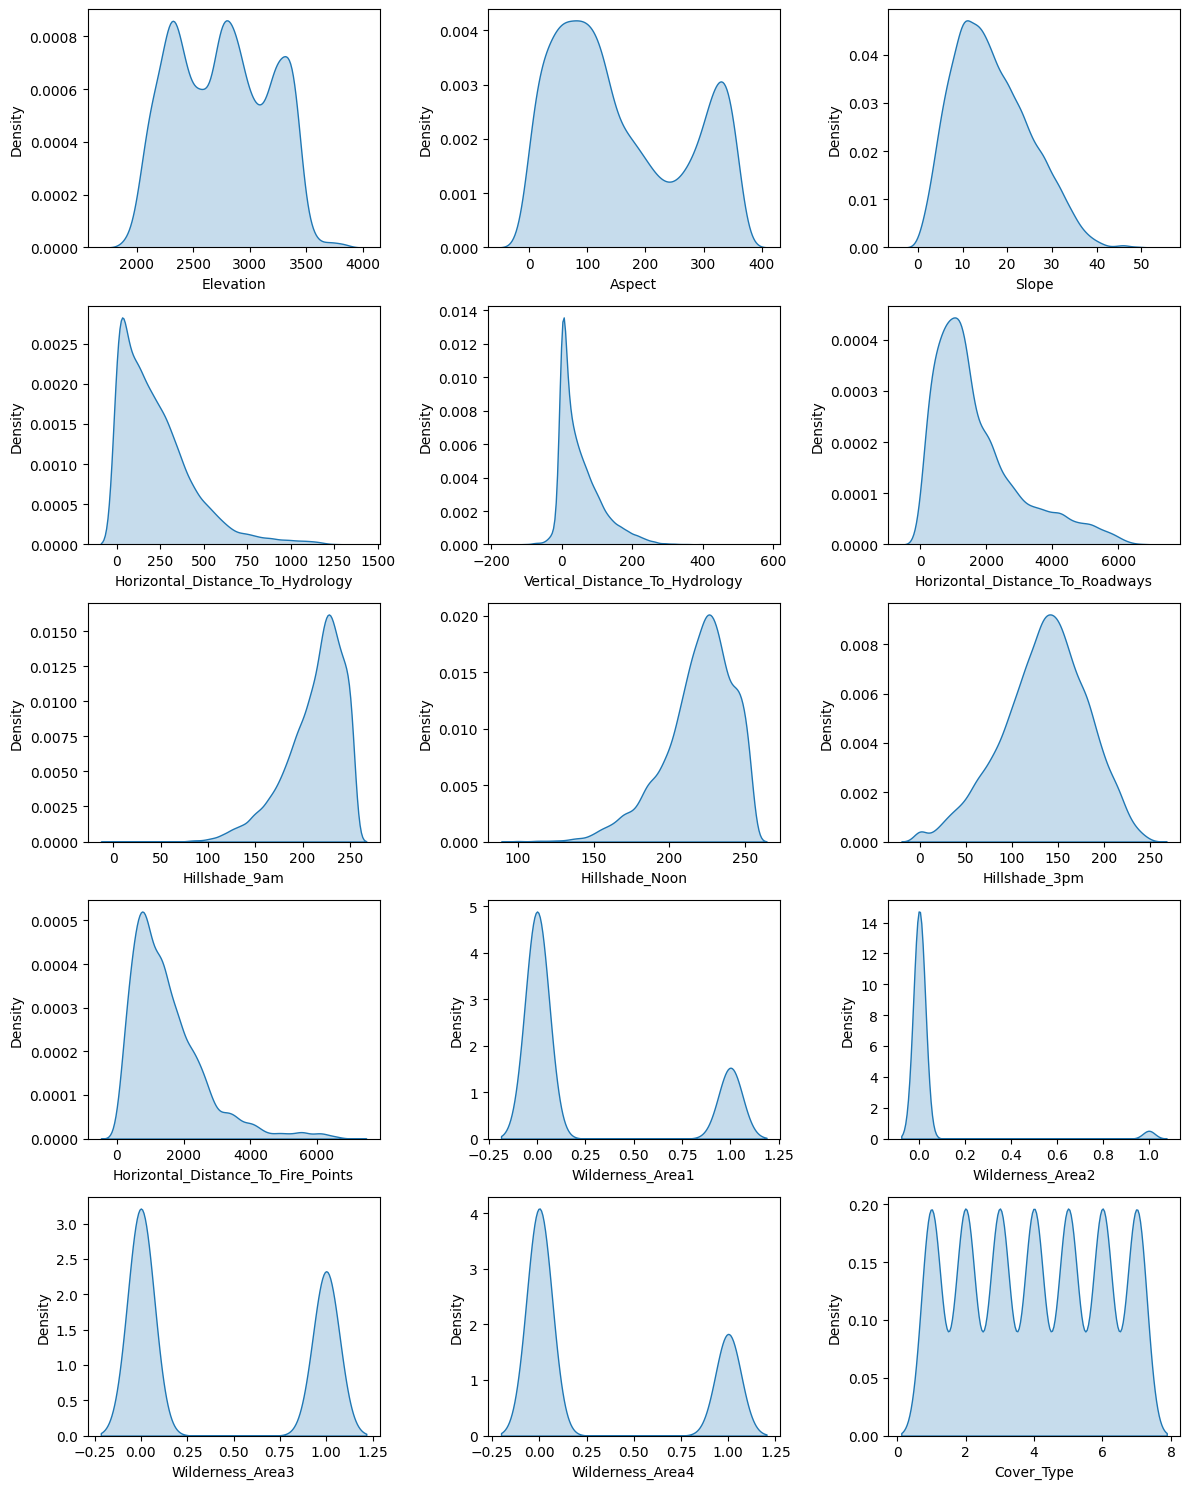

In [29]:
# skewness check of individual features

# Number of features
features = df_temp.columns
n_features = len(features)

# Create subplots (2 columns layout)
fig, axes = plt.subplots((n_features + 1)//3, 3, figsize=(12, 3*n_features//3))
axes = axes.flatten()  # Flatten 2D axes array into 1D for easy indexing

# Loop through features
for i, col in enumerate(features):
    sns.kdeplot(df[col], fill=True, ax=axes[i])
# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Data pre-processing
In this block, I will perform the following pre-processing:
1. Test-train spliting of dataset
2. treating missing value and duplicate rows (if present)
3. scale/encode features using standard scalar

In [30]:
# test-train splitiing

X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=None)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12096, 54)
(3024, 54)
(12096,)
(3024,)


In [31]:
#check for missing values
X_train.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


In [32]:
# check for duplicate rows
len(df) - len(df.duplicated(subset=None, keep='first'))

0

In [33]:
# Define our pipeline of transformations to apply and in what order
pipe = Pipeline([('transfomer', PowerTransformer(method='yeo-johnson')),
                ('scaler', StandardScaler())])

In [34]:
numeric_pipe = pipe.fit(X_train)
numeric_pipe.transform(X_train)

array([[-0.92609127, -2.09419522,  1.4650809 , ..., -0.22401411,
        -0.21279501, -0.17614271],
       [ 0.35208822, -0.76953018, -0.70839154, ..., -0.22401411,
        -0.21279501, -0.17614271],
       [ 0.55900344,  0.2514987 , -0.04514775, ..., -0.22401411,
        -0.21279501, -0.17614271],
       ...,
       [ 0.53591488,  0.1769737 , -0.04514775, ..., -0.22401411,
        -0.21279501, -0.17614271],
       [ 0.38718936,  0.91310484, -1.18454305, ..., -0.22401411,
        -0.21279501, -0.17614271],
       [ 1.45614238, -0.56578754, -1.18454305, ...,  4.46400444,
        -0.21279501, -0.17614271]], shape=(12096, 54))

In [35]:
X_train

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
4679,2364,3,30,404,152,1107,166,169,129,95,...,0,0,0,0,0,0,0,0,0,0
6634,2883,62,10,365,51,690,229,218,121,1405,...,0,0,0,0,0,0,0,0,0,0
11459,2972,162,15,108,20,4195,233,243,136,5280,...,0,0,0,0,0,0,0,0,0,0
15053,2395,349,32,95,27,607,145,169,150,875,...,0,0,0,0,0,0,0,0,0,0
8222,3244,64,21,108,25,2521,234,194,82,408,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,2189,114,27,0,0,1464,254,200,55,525,...,0,0,0,0,0,0,0,0,0,0
13418,2317,124,5,0,0,595,229,236,140,560,...,0,0,0,0,0,0,0,0,0,0
5390,2962,153,15,95,23,1608,237,239,128,470,...,0,1,0,0,0,0,0,0,0,0
860,2898,254,7,30,6,4919,204,245,179,1552,...,0,0,0,0,0,0,0,0,0,0


### Feature Engineering
Removed features with low variance and selected best features using SelectKBest

In [36]:
numeric_features = X_train.select_dtypes(exclude="object").columns
len(numeric_features)

54

In [37]:
#removing low variance feature
# Setting a threshold of 0.01. Any feature with variance below this will be removed.
var_thresh = VarianceThreshold(threshold=0.01)  
X_var = var_thresh.fit_transform(X_train)

# Get retained feature names
selected_features = X_train.columns[var_thresh.get_support()]

# Convert to DataFrame
X_var_df = pd.DataFrame(X_var, columns=selected_features, index=X_train.index)

print("Remaining features after low-variance filter:", list(selected_features))
print(X_var_df.head())

Remaining features after low-variance filter: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type17', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
       Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
4679        2364       3     30                               404   
6634        2883      62     10                               365   
11459       2972     162     15                               108   
15053       2395     349     32

In [38]:
X_var.shape

(12096, 37)

In [39]:
selector = SelectKBest(score_func=f_classif, k=20)  
X_new = selector.fit_transform(X_var, y_train)  
X_new.shape

(12096, 20)

In [40]:
# Get the selected feature names
selected_features = X_var_df.columns[selector.get_support()]

# Convert to DataFrame
X_new_df = pd.DataFrame(X_new, columns=selected_features, index=X_var_df.index)

print("Selected features:", list(selected_features))
print(X_new_df.head())

Selected features: ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type3', 'Soil_Type4', 'Soil_Type10', 'Soil_Type17', 'Soil_Type22', 'Soil_Type29', 'Soil_Type30', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
       Elevation  Slope  Horizontal_Distance_To_Hydrology  \
4679        2364     30                               404   
6634        2883     10                               365   
11459       2972     15                               108   
15053       2395     32                                95   
8222        3244     21                               108   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_3pm  \
4679                              1107            166            129   
6634                               690            229            121   
11459                   

### Cross-validation setup

Using KFold CV

In [41]:
# Stratified KFold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Model selection

In [42]:
# Logistic Regression baseline
log_reg = LogisticRegression(
    max_iter=5000,
    solver='saga',
    n_jobs=-1
)
scores_lr = cross_val_score(log_reg, X_new_df, y_train, cv=skf, scoring="accuracy")

In [43]:
scores_lr

array([0.57603306, 0.58412567, 0.57916494, 0.58081852, 0.57999173])

In [44]:
# Decision Tree baseline
tree = DecisionTreeClassifier(random_state=42)
scores_tree = cross_val_score(tree, X_new_df, y_train, cv=skf, scoring="accuracy")

In [45]:
scores_tree

array([0.77479339, 0.75899132, 0.75237702, 0.75279041, 0.75899132])

In [46]:
print("Mean LR accuracy:", np.mean(scores_lr))
print("Mean Tree accuracy:", np.mean(scores_tree))

Mean LR accuracy: 0.580026785195713
Mean Tree accuracy: 0.7595886900877693


In [47]:
rf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)
scores_rf = cross_val_score(rf, X_new_df, y_train, cv=skf, scoring="accuracy")

print("Random Forest CV Accuracies:", scores_rf)
print("Mean RF accuracy:", np.mean(scores_rf))

Random Forest CV Accuracies: [0.85413223 0.84415048 0.8491112  0.84539066 0.8491112 ]
Mean RF accuracy: 0.8483791540114589


In [50]:
# Model
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)

# CV scoring
scores_xgb = cross_val_score(xgb,  X_new_df, y_train - 1, cv=skf, scoring="accuracy")
print("Accuracy per fold:", scores_xgb)
print("Mean Accuracy:", scores_xgb.mean())

C:\Users\muska\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:16:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\muska\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:16:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\muska\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:16:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 

Accuracy per fold: [0.84504132 0.83794957 0.84042993 0.83422902 0.83174866]
Mean Accuracy: 0.8378796989398666


In [51]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

scores_lgbm = cross_val_score(lgbm, X_new_df, y_train, cv=skf, scoring="accuracy")

print("LightGBM CV Accuracies:", scores_lgbm)
print("Mean LGBM accuracy:", np.mean(scores_lgbm))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 9676, number of used features: 20
[LightGBM] [Info] Start training from score -1.938907
[LightGBM] [Info] Start training from score -1.949015
[LightGBM] [Info] Start training from score -1.943948
[LightGBM] [Info] Start training from score -1.956299
[LightGBM] [Info] Start training from score -1.936754
[LightGBM] [Info] Start training from score -1.946117
[LightGBM] [Info] Start training from score -1.950468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [52]:
#comparing advanced models
results = {
    "Logistic Regression": np.mean(scores_lr),
    "Decision Tree": np.mean(scores_tree),
    "Random Forest": np.mean(scores_rf),
    "XGBoost": np.mean(scores_xgb),
    "LightGBM": np.mean(scores_lgbm)
}

print("\nModel Comparison (Mean Accuracy across folds):")
for model, score in results.items():
    print(f"{model}: {score:.4f}")


Model Comparison (Mean Accuracy across folds):
Logistic Regression: 0.5800
Decision Tree: 0.7596
Random Forest: 0.8484
XGBoost: 0.8379
LightGBM: 0.8533


### Hyperparameter tuning 

In [54]:
# Base LightGBM model
lgb_clf = lgb.LGBMClassifier(random_state=42)

In [55]:
# Hyperparameter grid
param_dist = {
    "num_leaves": [31, 50, 70, 100],
    "max_depth": [-1, 10, 20, 30],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [200, 500, 1000],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0]
}

In [56]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=30,   # number of parameter settings sampled
    scoring=make_scorer(accuracy_score),
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [62]:
# Fit
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 44
[LightGBM] [Info] Start training from score -1.939565
[LightGBM] [Info] Start training from score -1.949388
[LightGBM] [Info] Start training from score -1.943598
[LightGBM] [Info] Start training from score -1.955797
[LightGBM] [Info] Start training from score -1.936693
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.950551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [59]:
best_lgb = random_search.best_estimator_
best_lgb

,boosting_type,'gbdt'
,num_leaves,70
,max_depth,20
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Final Model Training and Evaluation

In [74]:
pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.01)),         # low variance filter
    ("select_best", SelectKBest(score_func=f_classif, k=35)),  # univariate selection
    ("clf", lgb.LGBMClassifier(**random_search.best_params_, random_state=42))
])

# Fit best model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Metrics
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 35
[LightGBM] [Info] Start training from score -1.939565
[LightGBM] [Info] Start training from score -1.949388
[LightGBM] [Info] Start training from score -1.943598
[LightGBM] [Info] Start training from score -1.955797
[LightGBM] [Info] Start training from score -1.936693
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.950551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\muska\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
